<a href="https://colab.research.google.com/github/ummadiviany/Pix2Pix/blob/main/Training_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pix2Pix Training Notebook



## Installing necessary libraries

In [1]:
!pip install -q albumentations==0.4.6
!pip install -q opendatasets

     |████████████████████████████████| 117 kB 4.3 MB/s 
     |████████████████████████████████| 948 kB 17.9 MB/s 


## Importing necessary libraries

In [2]:
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import DataLoader, Dataset
    import tqdm as tqdm
    from torchvision.utils import save_image, make_grid
    import albumentations as A
    from albumentations.pytorch import ToTensorV2
    import os
    import numpy as np
    from PIL import Image 
    from torchvision import datasets
    import matplotlib.pyplot as plt
    import opendatasets as od 
    %matplotlib inline
    import pandas as pd
    
    print("Successfully imported all libraries")
except:
    print("Errors in importing libraries")


Successfully imported all libraries


## Cloning git repo for model functions

In [3]:
!git clone https://github.com/ummadiviany/Pix2Pix

Cloning into 'Pix2Pix'...
remote: Enumerating objects: 96, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 96 (delta 25), reused 37 (delta 12), pack-reused 0
Unpacking objects: 100% (96/96), done.


In [4]:
from Pix2Pix.training_notebooks.generator_model import Generator
from Pix2Pix.training_notebooks.discriminator_model import Discriminator
from Pix2Pix.training_notebooks.dataset import MapDataset
from Pix2Pix.training_notebooks.additional_functions import test_on_val_data

## Datasets download
Use the below kaggle usename and key for dataset download
1. Below code cell prompts for kaggle username, copy the username from below and paste and hit ⌨Enter key.
2. Again prompts for kaggle secure key, copy the key from below and paste and hit ⌨Enter key.
- username ▶     **iamvinayummadi** 
- key:     ▶    **78f6cee94760fd02415c9024cba10173**

In [5]:
od.download('https://www.kaggle.com/vikramtiwari/pix2pix-dataset')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: iamvinayummadi
Your Kaggle Key: ··········


100%|██████████| 2.40G/2.40G [01:07<00:00, 38.3MB/s]


## Setting up hyperparameters

In [14]:
loss_df = pd.DataFrame(columns=['D_Loss','G_Loss'])
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device :',DEVICE)
TRAIN_DIR = "pix2pix-dataset/maps/maps/train"
VAL_DIR = "pix2pix-dataset/maps/maps/val"
LEARNING_RATE  = 3e-4
BATCH_SIZE = 32
NUM_WORKERS = 2
IMAGE_SIZE = 256
CHANNELS_IMG = 3
L1_LAMBDA = 100
LAMBDA_GP = 10
NUM_EPOCHS = 2

Device : cuda


## Loading training and validation data

In [15]:
train_dataset = MapDataset(root_dir= TRAIN_DIR, input_size=600,direction=0)
train_loader = DataLoader(train_dataset,batch_size= BATCH_SIZE,shuffle=True,num_workers= NUM_WORKERS)

val_dataset  = MapDataset(root_dir= VAL_DIR, input_size=600,direction=0)
validation_loader = DataLoader(val_dataset,batch_size=4,shuffle=True)

## Model instances, optimizers, learning_rate schedulers, and loss functions
1. Adam optimizer(lr = 2e-4,betas=(0.5,0.99) with stepwise learning rate decay is used. Learning rate decay by factor of 10 for every 20 epochs.
2. BCE Loss for Discriminator and BCE + L1 Loss for Generator

In [16]:
disc = Discriminator(in_channels=3).to( DEVICE)
gen_model = Generator(in_channels=3,features=64).to( DEVICE)

opt_disc = optim.Adam(disc.parameters(),lr= LEARNING_RATE,betas=(0.5,0.999))
opt_gen = optim.Adam(gen_model.parameters(),lr= LEARNING_RATE,betas=(0.5,0.999))

scheduler_disc = optim.lr_scheduler.StepLR(opt_disc, step_size=20, gamma=0.1)
scheduler_gen = optim.lr_scheduler.StepLR(opt_gen, step_size=20, gamma=0.1)

BCE = nn.BCEWithLogitsLoss()
L1_LOSS = nn.L1Loss()

## Training loop
* Prints Epoch, Batch, Discriminator Loss, Generator Loss
* Saves an Image📺 with name format input_label_gen_.png for visualization. Please check that image📺

In [17]:
for epoch in range( NUM_EPOCHS):
    print(f"Epoch[{epoch}/{NUM_EPOCHS}], Learning Rate = {opt_disc.param_groups[0]['lr']}")
    for idx,(inputs,outputs) in enumerate(train_loader):
        inputs,outputs=inputs.to( DEVICE), outputs.to( DEVICE)
        
        #Train Discriminator
        outputs_fake = gen_model(inputs)
        D_real = disc(inputs,outputs)
        D_real_loss = BCE(D_real,torch.ones_like(D_real))
        D_fake = disc(inputs,outputs_fake.detach())
        D_fake_loss = BCE(D_fake,torch.zeros_like(D_fake))
        D_loss = (D_real_loss+D_fake_loss)/2
        disc.zero_grad()
        D_loss.backward()
        opt_disc.step()
        
        # Train Generator
        D_fake = disc(inputs,outputs_fake)
        G_fake_loss = BCE(D_fake,torch.ones_like(D_fake))
        L1 = L1_LOSS(outputs_fake,outputs)* L1_LAMBDA
        G_loss = G_fake_loss+L1
        opt_gen.zero_grad()
        G_loss.backward()
        opt_gen.step()
        
        loss_df.loc[len(loss_df)] = [D_loss.mean().item(),G_loss.mean().item()]        
        loss_df.to_csv('losses.csv',index=False)
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]  Batch [{idx+1}/{len(train_loader)}] PatchGAN_Loss : {D_loss.mean().item():.4f}  Generator_Loss : {G_loss.mean().item():.4f}")
        test_on_val_data(epoch, "/content/", gen_model, validation_loader, DEVICE)
    print('See the generated image at/content/input_label_gen_.png')
    # Learning rate update with LR Scheduler
    scheduler_disc.step()
    scheduler_gen.step()

Epoch[0/2], Learning Rate = 0.0003
Epoch [1/2]  Batch [1/35] PatchGAN_Loss : 0.7096  Generator_Loss : 74.1735
Epoch [1/2]  Batch [2/35] PatchGAN_Loss : 0.9292  Generator_Loss : 64.8344
Epoch [1/2]  Batch [3/35] PatchGAN_Loss : 0.7779  Generator_Loss : 57.0326
Epoch [1/2]  Batch [4/35] PatchGAN_Loss : 0.7826  Generator_Loss : 49.2619
Epoch [1/2]  Batch [5/35] PatchGAN_Loss : 0.7269  Generator_Loss : 47.2645
Epoch [1/2]  Batch [6/35] PatchGAN_Loss : 0.7682  Generator_Loss : 43.0242
Epoch [1/2]  Batch [7/35] PatchGAN_Loss : 0.6715  Generator_Loss : 38.8558
Epoch [1/2]  Batch [8/35] PatchGAN_Loss : 0.6841  Generator_Loss : 36.0363
Epoch [1/2]  Batch [9/35] PatchGAN_Loss : 0.6628  Generator_Loss : 33.6820
Epoch [1/2]  Batch [10/35] PatchGAN_Loss : 0.6464  Generator_Loss : 33.2697
Epoch [1/2]  Batch [11/35] PatchGAN_Loss : 0.6352  Generator_Loss : 31.1572
Epoch [1/2]  Batch [12/35] PatchGAN_Loss : 0.6179  Generator_Loss : 29.3673
Epoch [1/2]  Batch [13/35] PatchGAN_Loss : 0.6190  Generator_L

## Plotting Loss values

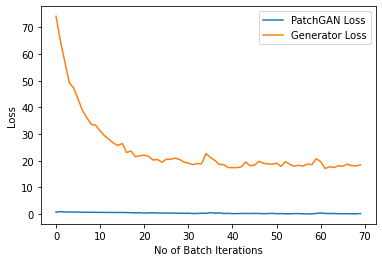

In [18]:
df_loss = pd.read_csv('losses.csv')
plt.plot(df_loss['D_Loss'],label='PatchGAN Loss')
plt.plot(df_loss['G_Loss'],label='Generator Loss')
plt.xlabel('No of Batch Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()